In [13]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from importlib import reload
from time import time 

import numpy as np
import scipy as sc
import pandas as pd
import torch

import gb1
from utils import str2onehot

import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams["font.size"] = 12

import seaborn as sns
sns.set_style('whitegrid')

MODEL_PATH = '/homefs/home/wongfanc/density-ratio-estimation/gb1-models/'

# load data, model, design distributions

160000 160000 (160000, 4, 21)


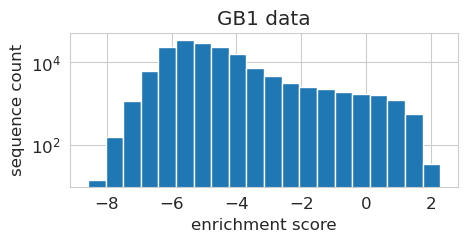

In [14]:
# load data
df = pd.read_csv('../data/gb1-with-variance.csv')
seq_n = list(df['Variants'].str.lower())
y_n = df['log_fitness'].to_numpy()
var_n = df['estimated_variance'].to_numpy()
seq2yvar = {seq: [y, var] for seq, y, var in zip(seq_n, y_n, var_n)}
ohe_nxlxa = np.stack([str2onehot(seq, gb1.AA) for seq in seq_n])
print(len(seq_n), y_n.size, ohe_nxlxa.shape)

plt.figure(figsize=(5, 2))
plt.hist(y_n, bins=20, log=True);
plt.xlabel('enrichment score');
plt.ylabel('sequence count');
plt.title('GB1 data');

True mean of NNK distribution: -4.8086


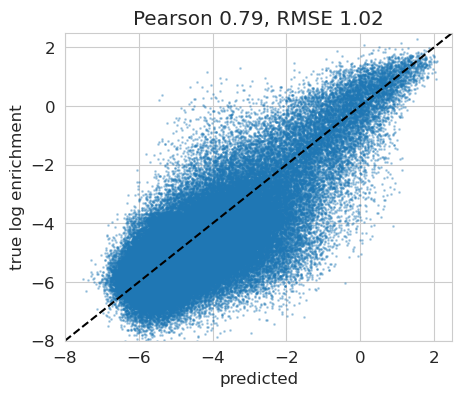

In [15]:
# load model
reload(gb1)
n_hidden = 10
n_model = 3
device = torch.device(0)

model = gb1.EnrichmentFeedForward(
    n_hidden=n_hidden,
    n_model=n_model,
    device=device
)
model.load('gb1-h10-5k-030123')

# load all design distributions
# temp2theta is a dictionary that maps real-valued temperature to the corresponding
# design distribution, which is parameterized by a seq_len X 4 matrix called theta_lxa.
# each row of theta_lxa gives the logits of a categorical distribution over the 4 nucleotides
# at a site. there are a total of seq_len nucleotide sites, where
# seq_len = (# protein residues) * 3 because there are 3 nucleotides per codon,
# and (# protein residues) = 4 for this dataset.
temperatures = np.arange(0.2, 0.701, 0.001)
temp2theta = {
    temp: np.load(MODEL_PATH + 'gb1-h10-5k-t{:.4f}-030123.npz'.format(temp))['theta_lxa']
    for temp in temperatures
}

# true mean of NNK distribution, for reference
pnnk_n = np.exp(gb1.get_nostop_loglikelihood(gb1.ALL_NOSTOP_AA_OHE, gb1.PAA_NNK_LXA))
truemean = np.sum([p * seq2yvar[seq][0] for p, seq in zip(pnnk_n, gb1.ALL_NOSTOP_AA_SEQS)])
print('True mean of NNK distribution: {:.4f}'.format(truemean))

# true means of design distributions
temp2mean = gb1.get_true_mean_label_from_theta(temp2theta) 

# sanity-check: plot model predictions on all data
pred_n = model.predict(seq_n)
plt.figure(figsize=(5, 4))
plt.scatter(pred_n, y_n, alpha=0.3, s=1)
plt.plot([-8, 2.5], [-8, 2.5], '--k')
r, p = sc.stats.pearsonr(y_n, pred_n)
rmse = np.sqrt(np.mean(np.square(y_n - pred_n)))

plt.ylim([-8, 2.5]);
plt.xlim([-8, 2.5])
plt.title('Pearson {:.2f}, RMSE {:.2f}'.format(r, rmse));
plt.ylabel('true log enrichment'); plt.xlabel('predicted');

In [20]:
# load (subset of) design distributions
reload(gb1)
temperatures = np.arange(0.2, 0.701, 0.005)
temp2theta = {
    round(temp, 4): np.load(MODEL_PATH + 'gb1-h10-5k-t{:.4f}-030123.npz'.format(temp))['theta_lxa']
    for temp in temperatures
}
temp2mean = gb1.get_true_mean_label_from_theta(temp2theta, verbose=True)

# exceedance
threshold = 1.1  # corresponds to 2x WT enrichment
temp2exceedance = gb1.get_true_mean_label_from_theta(temp2theta, threshold=threshold, verbose=True)

True mean for temperature...
    0.2000 is 1.2971. (0 sec)
    0.2050 is 1.2467. (0 sec)
    0.2100 is 0.9515. (1 sec)
    0.2150 is 1.2657. (1 sec)
    0.2200 is 1.2318. (1 sec)
    0.2250 is 1.2354. (1 sec)
    0.2300 is 1.2292. (1 sec)
    0.2350 is 1.2251. (2 sec)
    0.2400 is 1.3865. (2 sec)
    0.2450 is 1.2061. (2 sec)
    0.2500 is 1.1846. (2 sec)
    0.2550 is 1.3649. (2 sec)
    0.2600 is 1.0819. (3 sec)
    0.2650 is 1.0949. (3 sec)
    0.2700 is 1.0649. (3 sec)
    0.2750 is 1.3200. (3 sec)
    0.2800 is 0.6596. (3 sec)
    0.2850 is 1.2868. (4 sec)
    0.2900 is 1.1604. (4 sec)
    0.2950 is 1.0544. (4 sec)
    0.3000 is 1.1983. (4 sec)
    0.3050 is 1.2312. (4 sec)
    0.3100 is 1.1197. (5 sec)
    0.3150 is 1.1135. (5 sec)
    0.3200 is 1.2192. (5 sec)
    0.3250 is 1.1987. (5 sec)
    0.3300 is 1.1962. (5 sec)
    0.3350 is 0.7144. (6 sec)
    0.3400 is 1.1785. (6 sec)
    0.3450 is 1.0746. (6 sec)
    0.3500 is 1.1319. (6 sec)
    0.3550 is 1.1106. (6 sec)
    0.3600 

# (playing around, can skip)

In [121]:
# sample unlabeled sequences from design distribution for some extra temperatures
reload(gb1)

n_design = 1000000
save_path = '/homefs/home/wongfanc/density-ratio-estimation/gb1-results'
design_samples_fname_prefix = 'gb1-h10-5k-030123-samples'
t0 = time()

for temp in np.arange(0.2, 0.701, 0.005):
    design_samples_fname = os.path.join(save_path, '{}-t{:.4f}.npz'.format(design_samples_fname_prefix, temp))
    
    if os.path.isfile(design_samples_fname):
        print('Samples for temperature {:.4f} already saved to {}.'.format(temp, design_samples_fname))
    else:
        theta_lxa = temp2theta[round(temp, 4)]

        _, designohe_nxlxa, _ = gb1.sample_ohe_from_nuc_distribution(
            theta_lxa, n_design, normalize=True, reject_stop_codon=True
        )
        print('Sampled {} design sequences for temperature {:.2f} ({} s).'.format(n_design, temp, int(time() - t0)))

        np.savez(design_samples_fname, designohe_nxlxa=designohe_nxlxa)
        print('Saved design samples to {}.'.format(design_samples_fname))

Samples for temperature 0.2000 already saved to /homefs/home/wongfanc/density-ratio-estimation/gb1-results/gb1-h10-5k-030123-samples-t0.2000.npz.
Sampled 1000000 design sequences for temperature 0.21 (19 s).
Saved design samples to /homefs/home/wongfanc/density-ratio-estimation/gb1-results/gb1-h10-5k-030123-samples-t0.2050.npz.
Samples for temperature 0.2100 already saved to /homefs/home/wongfanc/density-ratio-estimation/gb1-results/gb1-h10-5k-030123-samples-t0.2100.npz.
Sampled 1000000 design sequences for temperature 0.22 (44 s).
Saved design samples to /homefs/home/wongfanc/density-ratio-estimation/gb1-results/gb1-h10-5k-030123-samples-t0.2150.npz.
Samples for temperature 0.2200 already saved to /homefs/home/wongfanc/density-ratio-estimation/gb1-results/gb1-h10-5k-030123-samples-t0.2200.npz.
Sampled 1000000 design sequences for temperature 0.23 (66 s).
Saved design samples to /homefs/home/wongfanc/density-ratio-estimation/gb1-results/gb1-h10-5k-030123-samples-t0.2250.npz.
Samples fo

Sampled 1000000 design sequences for temperature 0.46 (584 s).
Saved design samples to /homefs/home/wongfanc/density-ratio-estimation/gb1-results/gb1-h10-5k-030123-samples-t0.4550.npz.
Samples for temperature 0.4600 already saved to /homefs/home/wongfanc/density-ratio-estimation/gb1-results/gb1-h10-5k-030123-samples-t0.4600.npz.
Sampled 1000000 design sequences for temperature 0.47 (608 s).
Saved design samples to /homefs/home/wongfanc/density-ratio-estimation/gb1-results/gb1-h10-5k-030123-samples-t0.4650.npz.
Samples for temperature 0.4700 already saved to /homefs/home/wongfanc/density-ratio-estimation/gb1-results/gb1-h10-5k-030123-samples-t0.4700.npz.
Sampled 1000000 design sequences for temperature 0.48 (630 s).
Saved design samples to /homefs/home/wongfanc/density-ratio-estimation/gb1-results/gb1-h10-5k-030123-samples-t0.4750.npz.
Samples for temperature 0.4800 already saved to /homefs/home/wongfanc/density-ratio-estimation/gb1-results/gb1-h10-5k-030123-samples-t0.4800.npz.
Sampled

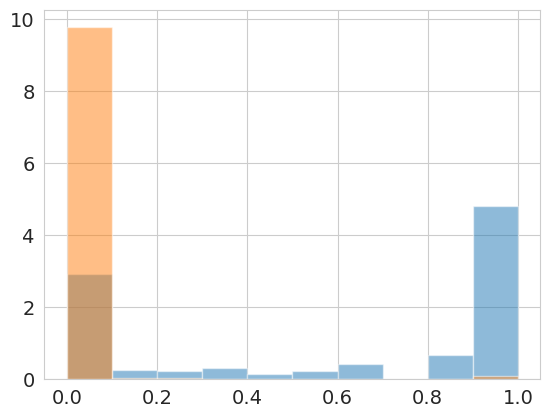

In [90]:
# try out training LR predictor of exceedance
reload(gb1)
n_train = 100
threshold = 1.1

train_idx = np.random.choice(n_train, len(seq_n))
ytrain_n = (y_n[train_idx] >= threshold).astype(float)
ohetrain_nxlxa = ohe_nxlxa[train_idx]
test_idx = np.random.choice(10000, len(seq_n))
ytest_n = (y_n[test_idx] >= threshold).astype(float)
ohetest_nxlxa = ohe_nxlxa[test_idx]

exceedance_model = gb1.ExceedancePredictor(model, threshold)
exceedance_model.fit(ohetrain_nxlxa, ytrain_n)
predtest_n = exceedance_model.predict(ohetest_nxlxa)
plt.figure(figsize=(4, 3))
plt.hist(predtest_n[ytest_n == 1], alpha=0.5, density=True, label='label = 1');
plt.hist(predtest_n[ytest_n == 0], alpha=0.5, density=True, label='label = 1');
plt.xlabel('predicted logit');
plt.ylabel('test density');
plt.legend()
plt.title('logistic regression\nexceedance threshold = {}, # train = {}'.format(threshold, n_train))

# run design algorithm selection experiments

In [ ]:
reload(gb1)

# TOGGLE FOR EXCEEDANCE:
run_exceedance = True
target_values = np.arange(0.0, 1.01, 0.1) # np.arange(0.0, 1.21, 0.1)
n_train_lr = 1000 # 0

# no need to toggle for exceedance
n_cal = 5000
alpha = 0.1
n_trial = 500
n_design = 1000000
results_csv_fname = 'gb1-h10-5k-ncal{}{}-030123.csv'.format(
    n_cal, '_exceed{}'.format(threshold) if run_exceedance else ''
)
save_design_samples = False
load_design_samples = True

design_samples_fname_prefix = 'gb1-h10-5k-030123-samples'

df = gb1.run_temperature_selection_experiments(
    model,
    temp2theta,
    target_values,
    exceedance_threshold=threshold if run_exceedance else None,
    n_cal=n_cal,
    n_train_lr=n_train_lr,
    n_design=n_design,
    alpha=alpha,
    n_trial=n_trial,
    results_csv_fname=results_csv_fname,
    design_samples_fname_prefix=design_samples_fname_prefix,
    save_design_samples=save_design_samples,
    load_design_samples=load_design_samples
)

Selection quantity is probability of exceeding 1.1.
Range of provided target values: [0.0000, 1.0000].

Loaded 1000000 design sequences from /homefs/home/wongfanc/density-ratio-estimation/gb1-results/gb1-h10-5k-030123-samples-t0.2000.npz.


In [207]:
# compute plottable quantities
impworst_v = []
ppworst_v = []
imperr_v = []
pperr_v = []
impdisc_v = []
ppdisc_v = []
val2impselected = {}
val2ppselected = {}

t0 = time()
for v, val in enumerate(target_values):
    
    worst_imp_true_values_t = []
    worst_pp_true_values_t = []
    imp_selected_minmax_t = []
    pp_selected_minmax_t = []
    
    for j in range(n_trial):
        imp_selected_temps = [t for t in temperatures if df.loc[val]['tr{}_imp_selected_temp{:.4f}'.format(j, t)]]
        imp_true_values = [
            temp2exceedance[round(t, 4)] if run_exceedance else temp2mean[round(t, 4)]
            for t in imp_selected_temps
        ]
        if len(imp_true_values):
            worst_imp_true_values_t.append(np.min(imp_true_values))
            imp_selected_minmax_t.append([np.min(imp_selected_temps), np.max(imp_selected_temps)])
        else:
            imp_selected_minmax_t.append([])
        
        pp_selected_temps = [t for t in temperatures if df.loc[val]['tr{}_pp_selected_temp{:.4f}'.format(j, t)]]
        pp_true_values = [
            temp2exceedance[round(t, 4)] if run_exceedance else temp2mean[round(t, 4)]
            for t in pp_selected_temps
        ]
        if len(pp_true_values):
            worst_pp_true_values_t.append(np.min(pp_true_values))
            pp_selected_minmax_t.append([np.min(pp_selected_temps), np.max(pp_selected_temps)])
        else:
            pp_selected_minmax_t.append([])
    
    val2impselected[round(val, 4)] = imp_selected_minmax_t
    val2ppselected[round(val, 4)] = pp_selected_minmax_t
            
    impworst_v.append(worst_imp_true_values_t)
    ppworst_v.append(worst_pp_true_values_t)
    imperr_v.append(np.sum(np.array(worst_imp_true_values_t) < val) / n_trial)
    pperr_v.append(np.sum(np.array(worst_pp_true_values_t) < val) / n_trial)
    impdisc_v.append(len(worst_imp_true_values_t) / n_trial)
    ppdisc_v.append(len(worst_pp_true_values_t) / n_trial)

print('{} s'.format(int(time() - t0)))
    

31 s


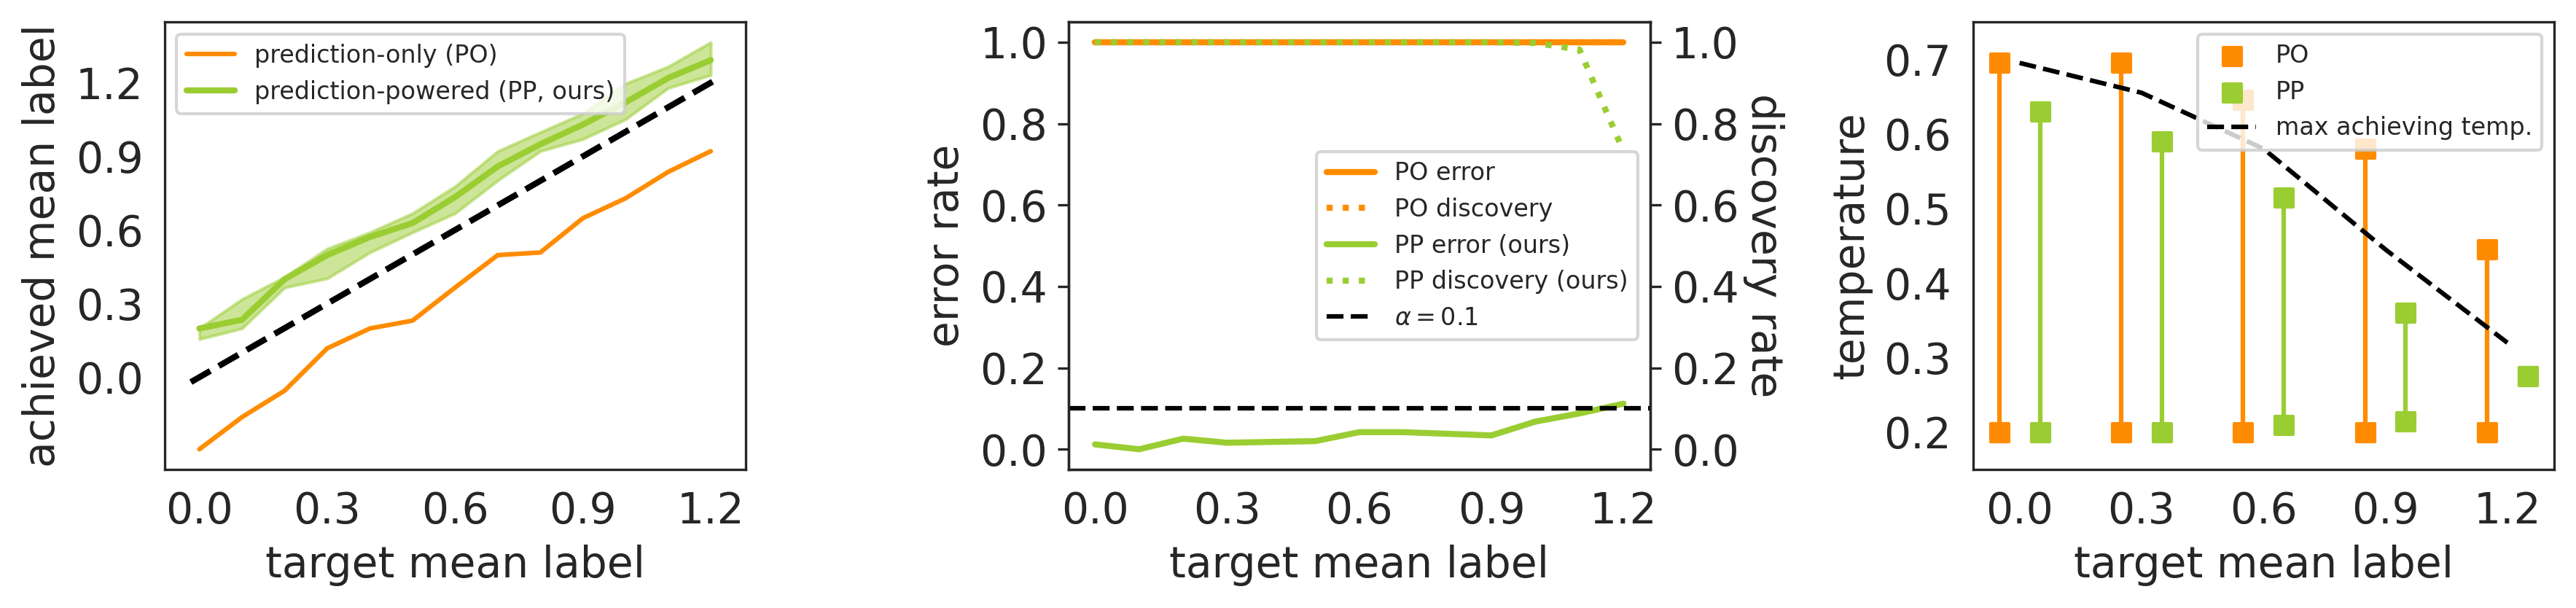

In [270]:
# plot results
plt.rcParams["font.size"] = 14
sns.set_style('white')
fig, axs = plt.subplots(1, 3, figsize=(12, 3), dpi=300)

imp_color = 'darkorange'
pp_color = 'yellowgreen'
q_low = 0.25
q_high = 0.75
trial_idx = 451
offset = 0.05
example_targets = np.arange(np.min(target_values), np.max(target_values), 0.3)

axs[0].plot(
    [np.min(target_values) - 0.02, np.max(target_values) + 0.02],
    [np.min(target_values) - 0.02, np.max(target_values) + 0.02],
    '--k', linewidth=2
);
axs[0].plot(
    target_values, [np.median(worst) for worst in impworst_v],
    c=imp_color, label='prediction-only (PO)', linewidth=1.5,
)
axs[0].fill_between(
    target_values, [np.quantile(worst, q_low) for worst in impworst_v],
    [np.quantile(worst, q_high) for worst in impworst_v],
    color=imp_color, alpha=0.5
)
axs[0].plot(
    target_values, [np.median(worst) for worst in ppworst_v],
    c=pp_color, label='prediction-powered (PP, ours)', linewidth=2,
)
axs[0].fill_between(
    target_values, [np.quantile(worst, q_low) for worst in ppworst_v],
    [np.quantile(worst, q_high) for worst in ppworst_v],
    color=pp_color, alpha=0.5, # label='PP ({:.2f} - {:.2f})'.format(q_low, q_high)
)
axs[0].legend(fontsize=8)
axs[0].set_xlabel('target mean label');
axs[0].set_ylabel('achieved mean label');
axs[0].set_xticks(np.arange(np.min(target_values), np.max(target_values), 0.3))
axs[0].set_yticks(np.arange(np.min(target_values), np.max(target_values), 0.3))

axs[1].set_ylabel('error rate');
axs[1].set_xlabel('target mean label');
axs[1].set_ylim([-0.05, 1.05])
axs[1].set_xticks(np.arange(np.min(target_values), np.max(target_values), 0.3))
axs[1].set_yticks(np.arange(0, 1.1, 0.2))

disc_ax = axs[1].twinx()
disc_ax.plot(target_values, imperr_v, c=imp_color, linewidth=2, label='PO error');
disc_ax.plot(target_values, impdisc_v, ':', c=imp_color, linewidth=2, label='PO discovery');
disc_ax.plot(target_values, pperr_v, c=pp_color, linewidth=2, label='PP error (ours)');
disc_ax.plot(target_values, ppdisc_v, ':', c=pp_color, linewidth=2, label='PP discovery (ours)');
disc_ax.axhline(alpha, linestyle='--', color='k', linewidth=1.5, label=r'$\alpha = {}$'.format(alpha));
disc_ax.legend(fontsize=8)
disc_ax.set_ylabel('discovery rate', rotation=270, labelpad=15);
disc_ax.set_yticks(np.arange(0, 1.1, 0.2))

maxtemp_v = []
for v, val in enumerate(example_targets):
    maxtemp_v.append(np.max([t for t in temperatures if temp2mean[round(t, 4)] >= val]))
    axs[2].plot([val - offset, val - offset], val2impselected[round(val, 4)][trial_idx], c=imp_color)
    axs[2].scatter(
        [val - offset, val - offset], val2impselected[round(val, 4)][trial_idx],
        marker='s', c=imp_color, label='PO' if v == 0 else None
    )
    axs[2].plot([val + offset, val + offset], val2ppselected[round(val, 4)][trial_idx], c=pp_color)
    axs[2].scatter(
        [val + offset, val + offset], val2ppselected[round(val, 4)][trial_idx],
        marker='s', c=pp_color, label='PP' if v == 0 else None
    )
axs[2].plot(example_targets, maxtemp_v, '--k', linewidth=1.5, label='max achieving temp.')
axs[2].legend(fontsize=8)
axs[2].set_ylim([0.15, 0.75])
axs[2].set_ylabel('temperature');
axs[2].set_xlabel('target mean label')
axs[2].set_xticks(np.arange(np.min(target_values), np.max(target_values), 0.3))
axs[2].set_yticks(np.arange(0.2, 0.71, 0.1))

fig.tight_layout()